<a href="https://colab.research.google.com/github/soaresbru/bootcamp-Unimed-Data-science/blob/main/cachorro_ou_gato.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# importando as bibliotecas
# Importando as bibliotecas padrões
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Importando a biblioteca para carregar arquivos do drive
from google.colab import drive


from keras.preprocessing.image import ImageDataGenerator
from keras_preprocessing.image import load_img
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import os
import random

Os dados para realizar esse notebook foram retirados do Kaggle: https://www.kaggle.com/competitions/dogs-vs-cats

Como todas as imagens juntas era demais, levaria muito tempo para o processamento
Então decidi fazer com cerca de 300 imagens de gatos e 300 imagens de cachorro

In [ ]:
# Montando Google Drive
drive.mount('/content/drive')

# Caminho para pegar os arquivos do drive
caminho = '/content/drive/MyDrive/Dataset - projetos dados/dogs-vs-cats/treino'  

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Agora vamos separar as fotos que são referentes aos cachorros ou gatos
nome_arquivos = os.listdir(caminho)
tipos = []
for nome_arquivo in nome_arquivos:
    tipo = nome_arquivo.split('.')[0]
    if tipo == 'cat':
        tipos.append(0)
    else:
        tipos.append(1)

df = pd.DataFrame({
    'nome_arquivo': nome_arquivos,
    'tipo': tipos
})

In [ ]:
# Olhando se a tabela está certinha
df.head()

,nome_arquivo,tipo
0,cat.0.jpg,0
1,cat.1.jpg,0
2,cat.10.jpg,0
3,cat.100.jpg,0
4,cat.101.jpg,0


In [ ]:
# Contando os valores de cada tipo para ver se está certo
df['tipo'].value_counts()

0    301
1    301
Name: tipo, dtype: int64

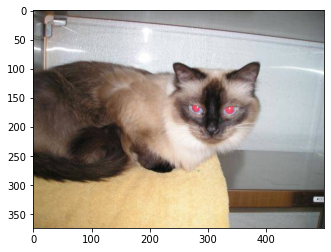

In [ ]:
# Pegando uma imagem para ver se está correto
exemplo = random.choice(nome_arquivos)
image = load_img(caminho+'/'+exemplo)
plt.imshow(image)

In [ ]:
# O modelo pode não entender muito bem caso o tamanho das imagens seja diferente, então vamos deixar aproximadamente igual
FAST_RUN = False
IMAGE_WIDTH=128
IMAGE_HEIGHT=128
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3

Aqui é muito importante entender o que está sendo feito, e os termos utilizados, portanto vou passar um resumo, caso queira saber um pouco mais eu indico o canal do sandeco:  
 https://www.youtube.com/c/canalsandeco  
 Em especial a playlist de redes convolucionais


Dropout- ajuda a regularizar(generalizar) a rede neural, "escondendo neuronios"   
Flatten - Converte imagem em dado estruturado   
Activation - São essenciais para dar capacidade representativa às redes neurais 
BatchNormalization - É um metodo usado para deixar o treino mais rápido e estável através da normalização
Pooling - Serve para reduzir a imagem
Padding - Serve para o output da convolução ficar no tamanho original  

In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax')) # 2 because we have cat and dog classes

model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 126, 126, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 63, 63, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 batch_normalization_1 (Batc  (None, 61, 61, 64)       2

In [ ]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [ ]:
earlystop = EarlyStopping(patience=10)

In [ ]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [ ]:
callbacks = [earlystop, learning_rate_reduction]

In [ ]:
df["category"] = df["category"].replace({0: 'cat', 1: 'dog'}) 

In [ ]:
train_df, validate_df = train_test_split(df, test_size=0.20, random_state=42)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

In [ ]:
train_df['category'].value_counts()

NameError: ignored

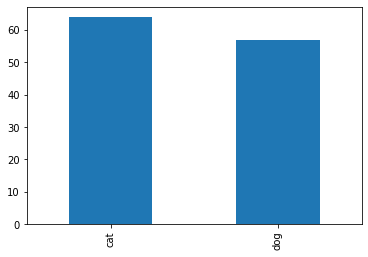

In [ ]:
validate_df['category'].value_counts()

In [ ]:
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]
batch_size=15

Data Augmentation - Aumenta a quantidade de dados modificando uma imagem, mudando por exemplo a rotação, o brilho, o zoom, espelhando, entre outros.

In [ ]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    caminho, 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 481 validated image filenames belonging to 2 classes.


In [ ]:
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    caminho, 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 121 validated image filenames belonging to 2 classes.


In [ ]:
example_df = train_df.sample(n=1).reset_index(drop=True)
example_generator = train_datagen.flow_from_dataframe(
    example_df, 
    caminho, 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical'
)

Found 1 validated image filenames belonging to 1 classes.


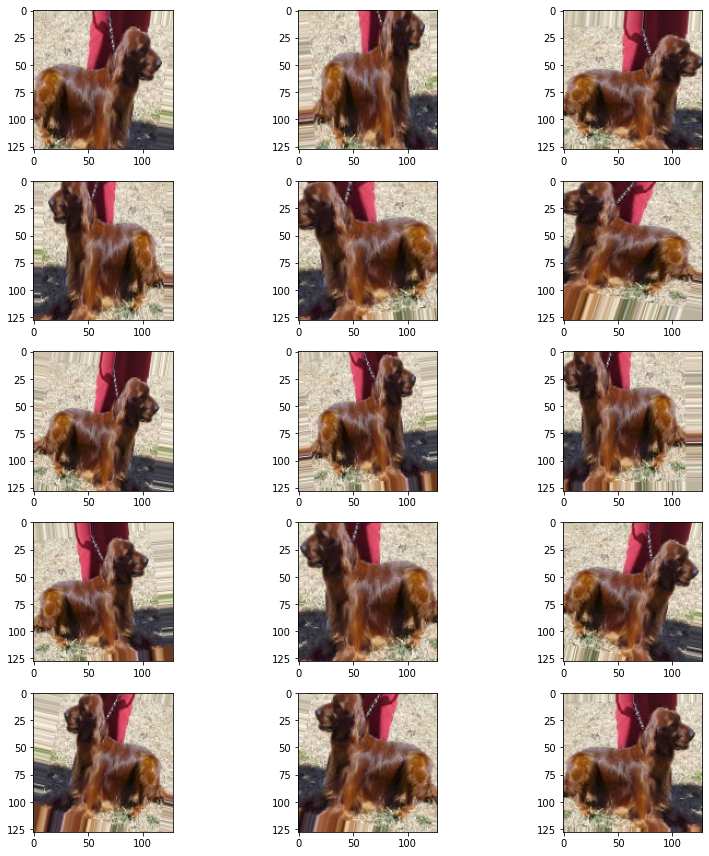

In [ ]:
plt.figure(figsize=(12, 12))
for i in range(0, 15):
    plt.subplot(5, 3, i+1)
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

In [ ]:
epochs=3 if FAST_RUN else 50
history = model.fit_generator(
    train_generator, 
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=callbacks
)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Epoch 1/50
32/32 [==============================] - ETA: 0s - loss: 1.6148 - accuracy: 0.5536

32/32 [==============================] - 205s 6s/step - loss: 1.6148 - accuracy: 0.5536 - val_loss: 3.5775 - val_accuracy: 0.4667 - lr: 0.0010
Epoch 2/50
32/32 [==============================] - ETA: 0s - loss: 1.2180 - accuracy: 0.5579

32/32 [==============================] - 27s 847ms/step - loss: 1.2180 - accuracy: 0.5579 - val_loss: 4.6436 - val_accuracy: 0.4667 - lr: 0.0010
Epoch 3/50
32/32 [==============================] - ETA: 0s - loss: 0.9847 - accuracy: 0.6137

32/32 [==============================] - 25s 780ms/step - loss: 0.9847 - accuracy: 0.6137 - val_loss: 1.5738 - val_accuracy: 0.4750 - lr: 0.0010
Epoch 4/50
32/32 [==============================] - ETA: 0s - loss: 0.9764 - accuracy: 0.6073

32/32 [==============================] - 27s 844ms/step - loss: 0.9764 - accuracy: 0.6073 - val_loss: 0.7027 - val_accuracy: 0.5750 - lr: 0.0010
Epoch 5/50
32/32 [==============================] - ETA: 0s - loss: 0.9471 - accuracy: 0.6009

32/32 [==============================] - 27s 853ms/step - loss: 0.9471 - accuracy: 0.6009 - val_loss: 3.0218 - val_accuracy: 0.4667 - lr: 0.0010
Epoch 6/50
32/32 [==============================] - ETA: 0s - loss: 0.8875 - accuracy: 0.6009

32/32 [==============================] - 27s 842ms/step - loss: 0.8875 - accuracy: 0.6009 - val_loss: 2.9699 - val_accuracy: 0.5333 - lr: 0.0010
Epoch 7/50
32/32 [==============================] - ETA: 0s - loss: 0.7950 - accuracy: 0.6459

32/32 [==============================] - 25s 787ms/step - loss: 0.7950 - accuracy: 0.6459 - val_loss: 1.0248 - val_accuracy: 0.4917 - lr: 0.0010
Epoch 8/50
32/32 [==============================] - ETA: 0s - loss: 0.8003 - accuracy: 0.6416

32/32 [==============================] - 27s 844ms/step - loss: 0.8003 - accuracy: 0.6416 - val_loss: 1.5810 - val_accuracy: 0.5250 - lr: 0.0010
Epoch 9/50
32/32 [==============================] - ETA: 0s - loss: 0.6992 - accuracy: 0.6738

32/32 [==============================] - 25s 787ms/step - loss: 0.6992 - accuracy: 0.6738 - val_loss: 0.6795 - val_accuracy: 0.6583 - lr: 0.0010
Epoch 10/50
32/32 [==============================] - ETA: 0s - loss: 0.7583 - accuracy: 0.6481

32/32 [==============================] - 27s 844ms/step - loss: 0.7583 - accuracy: 0.6481 - val_loss: 0.9111 - val_accuracy: 0.5500 - lr: 0.0010
Epoch 11/50
32/32 [==============================] - ETA: 0s - loss: 0.7160 - accuracy: 0.6674

32/32 [==============================] - 25s 790ms/step - loss: 0.7160 - accuracy: 0.6674 - val_loss: 1.3509 - val_accuracy: 0.5333 - lr: 0.0010
Epoch 12/50
32/32 [==============================] - ETA: 0s - loss: 0.6574 - accuracy: 0.6545

32/32 [==============================] - 27s 844ms/step - loss: 0.6574 - accuracy: 0.6545 - val_loss: 1.1732 - val_accuracy: 0.5500 - lr: 0.0010
Epoch 13/50
32/32 [==============================] - ETA: 0s - loss: 0.6721 - accuracy: 0.6717

32/32 [==============================] - 27s 846ms/step - loss: 0.6721 - accuracy: 0.6717 - val_loss: 0.9551 - val_accuracy: 0.5833 - lr: 0.0010
Epoch 14/50
32/32 [==============================] - ETA: 0s - loss: 0.6908 - accuracy: 0.6438

32/32 [==============================] - 25s 789ms/step - loss: 0.6908 - accuracy: 0.6438 - val_loss: 0.5870 - val_accuracy: 0.6917 - lr: 0.0010
Epoch 15/50
32/32 [==============================] - ETA: 0s - loss: 0.6040 - accuracy: 0.7082

32/32 [==============================] - 27s 849ms/step - loss: 0.6040 - accuracy: 0.7082 - val_loss: 0.8997 - val_accuracy: 0.4583 - lr: 0.0010
Epoch 16/50
32/32 [==============================] - ETA: 0s - loss: 0.5641 - accuracy: 0.7039

32/32 [==============================] - 27s 848ms/step - loss: 0.5641 - accuracy: 0.7039 - val_loss: 0.5592 - val_accuracy: 0.7250 - lr: 0.0010
Epoch 17/50
32/32 [==============================] - ETA: 0s - loss: 0.5535 - accuracy: 0.7446

32/32 [==============================] - 25s 777ms/step - loss: 0.5535 - accuracy: 0.7446 - val_loss: 0.6428 - val_accuracy: 0.6333 - lr: 0.0010
Epoch 18/50
32/32 [==============================] - ETA: 0s - loss: 0.5737 - accuracy: 0.7124

32/32 [==============================] - 27s 842ms/step - loss: 0.5737 - accuracy: 0.7124 - val_loss: 0.8289 - val_accuracy: 0.5917 - lr: 0.0010
Epoch 19/50
32/32 [==============================] - ETA: 0s - loss: 0.5764 - accuracy: 0.7210

32/32 [==============================] - 27s 844ms/step - loss: 0.5764 - accuracy: 0.7210 - val_loss: 0.6647 - val_accuracy: 0.6417 - lr: 0.0010
Epoch 20/50
32/32 [==============================] - ETA: 0s - loss: 0.5500 - accuracy: 0.7403

32/32 [==============================] - 25s 783ms/step - loss: 0.5500 - accuracy: 0.7403 - val_loss: 0.8665 - val_accuracy: 0.6333 - lr: 0.0010
Epoch 21/50
32/32 [==============================] - ETA: 0s - loss: 0.5208 - accuracy: 0.7403

32/32 [==============================] - 27s 805ms/step - loss: 0.5208 - accuracy: 0.7403 - val_loss: 0.5334 - val_accuracy: 0.7167 - lr: 0.0010
Epoch 22/50
32/32 [==============================] - ETA: 0s - loss: 0.5690 - accuracy: 0.7318

32/32 [==============================] - 27s 842ms/step - loss: 0.5690 - accuracy: 0.7318 - val_loss: 0.6998 - val_accuracy: 0.7417 - lr: 0.0010
Epoch 23/50
32/32 [==============================] - ETA: 0s - loss: 0.5144 - accuracy: 0.7639

32/32 [==============================] - 27s 830ms/step - loss: 0.5144 - accuracy: 0.7639 - val_loss: 0.7218 - val_accuracy: 0.6083 - lr: 0.0010
Epoch 24/50
32/32 [==============================] - ETA: 0s - loss: 0.4703 - accuracy: 0.7639

32/32 [==============================] - 25s 781ms/step - loss: 0.4703 - accuracy: 0.7639 - val_loss: 0.4688 - val_accuracy: 0.7750 - lr: 0.0010
Epoch 25/50
32/32 [==============================] - ETA: 0s - loss: 0.5185 - accuracy: 0.7361

32/32 [==============================] - 26s 814ms/step - loss: 0.5185 - accuracy: 0.7361 - val_loss: 0.6963 - val_accuracy: 0.6500 - lr: 0.0010
Epoch 26/50
32/32 [==============================] - ETA: 0s - loss: 0.5680 - accuracy: 0.7339

32/32 [==============================] - 25s 782ms/step - loss: 0.5680 - accuracy: 0.7339 - val_loss: 0.5592 - val_accuracy: 0.7000 - lr: 0.0010
Epoch 27/50
32/32 [==============================] - ETA: 0s - loss: 0.4818 - accuracy: 0.7639

32/32 [==============================] - 27s 847ms/step - loss: 0.4818 - accuracy: 0.7639 - val_loss: 0.5862 - val_accuracy: 0.7167 - lr: 0.0010
Epoch 28/50
32/32 [==============================] - ETA: 0s - loss: 0.5247 - accuracy: 0.7403

32/32 [==============================] - 25s 783ms/step - loss: 0.5247 - accuracy: 0.7403 - val_loss: 0.6753 - val_accuracy: 0.6583 - lr: 0.0010
Epoch 29/50
32/32 [==============================] - ETA: 0s - loss: 0.4719 - accuracy: 0.7661

32/32 [==============================] - 29s 890ms/step - loss: 0.4719 - accuracy: 0.7661 - val_loss: 0.5500 - val_accuracy: 0.7167 - lr: 0.0010
Epoch 30/50
32/32 [==============================] - ETA: 0s - loss: 0.4596 - accuracy: 0.7704

32/32 [==============================] - 26s 779ms/step - loss: 0.4596 - accuracy: 0.7704 - val_loss: 0.5062 - val_accuracy: 0.7750 - lr: 0.0010
Epoch 31/50
32/32 [==============================] - ETA: 0s - loss: 0.4331 - accuracy: 0.7918

32/32 [==============================] - 27s 837ms/step - loss: 0.4331 - accuracy: 0.7918 - val_loss: 0.6620 - val_accuracy: 0.7250 - lr: 0.0010
Epoch 32/50
32/32 [==============================] - ETA: 0s - loss: 0.5106 - accuracy: 0.7768

32/32 [==============================] - 27s 843ms/step - loss: 0.5106 - accuracy: 0.7768 - val_loss: 0.4669 - val_accuracy: 0.7750 - lr: 0.0010
Epoch 33/50
32/32 [==============================] - ETA: 0s - loss: 0.4298 - accuracy: 0.8090

32/32 [==============================] - 25s 789ms/step - loss: 0.4298 - accuracy: 0.8090 - val_loss: 0.4818 - val_accuracy: 0.7667 - lr: 0.0010
Epoch 34/50
32/32 [==============================] - ETA: 0s - loss: 0.4212 - accuracy: 0.8090

32/32 [==============================] - 25s 782ms/step - loss: 0.4212 - accuracy: 0.8090 - val_loss: 0.4677 - val_accuracy: 0.8000 - lr: 0.0010
Epoch 35/50
32/32 [==============================] - ETA: 0s - loss: 0.4328 - accuracy: 0.7961

32/32 [==============================] - 27s 864ms/step - loss: 0.4328 - accuracy: 0.7961 - val_loss: 0.6729 - val_accuracy: 0.7083 - lr: 0.0010
Epoch 36/50
32/32 [==============================] - ETA: 0s - loss: 0.4600 - accuracy: 0.7983

32/32 [==============================] - 29s 907ms/step - loss: 0.4600 - accuracy: 0.7983 - val_loss: 0.8472 - val_accuracy: 0.6250 - lr: 0.0010
Epoch 37/50
32/32 [==============================] - ETA: 0s - loss: 0.4072 - accuracy: 0.8283

32/32 [==============================] - 25s 788ms/step - loss: 0.4072 - accuracy: 0.8283 - val_loss: 1.1729 - val_accuracy: 0.5667 - lr: 0.0010
Epoch 38/50
32/32 [==============================] - ETA: 0s - loss: 0.4244 - accuracy: 0.8069

32/32 [==============================] - 25s 787ms/step - loss: 0.4244 - accuracy: 0.8069 - val_loss: 0.8542 - val_accuracy: 0.6667 - lr: 0.0010
Epoch 39/50
32/32 [==============================] - ETA: 0s - loss: 0.4302 - accuracy: 0.7961

32/32 [==============================] - 27s 845ms/step - loss: 0.4302 - accuracy: 0.7961 - val_loss: 0.6616 - val_accuracy: 0.6750 - lr: 0.0010
Epoch 40/50
32/32 [==============================] - ETA: 0s - loss: 0.4392 - accuracy: 0.7961

32/32 [==============================] - 27s 843ms/step - loss: 0.4392 - accuracy: 0.7961 - val_loss: 0.5750 - val_accuracy: 0.7500 - lr: 0.0010
Epoch 41/50
32/32 [==============================] - ETA: 0s - loss: 0.4297 - accuracy: 0.8026

32/32 [==============================] - 25s 782ms/step - loss: 0.4297 - accuracy: 0.8026 - val_loss: 0.6769 - val_accuracy: 0.7500 - lr: 0.0010
Epoch 42/50
32/32 [==============================] - ETA: 0s - loss: 0.4173 - accuracy: 0.8047

32/32 [==============================] - 29s 910ms/step - loss: 0.4173 - accuracy: 0.8047 - val_loss: 0.6105 - val_accuracy: 0.7583 - lr: 0.0010


In [ ]:
model.save_weights("model.h5")

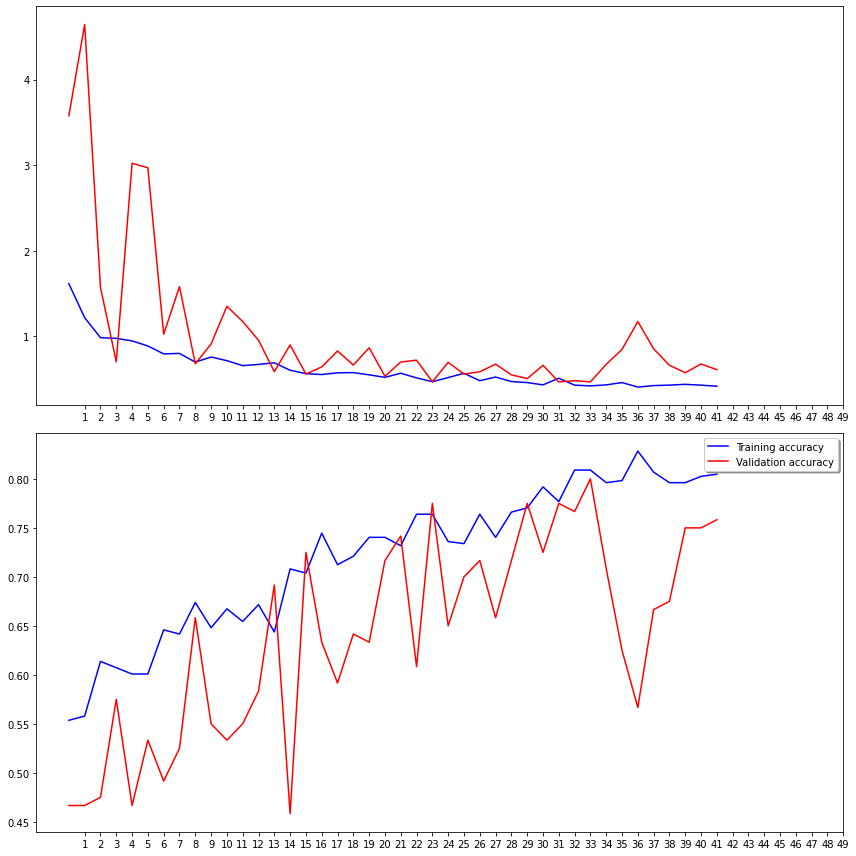

In [ ]:

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, epochs, 1))

ax2.plot(history.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, epochs, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()